In [1]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence

class ImageMaskGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size, img_size=(128, 128), shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.image_list = sorted(os.listdir(self.image_dir))
        self.mask_list = sorted(os.listdir(self.mask_dir))
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_list) / self.batch_size))

    def __getitem__(self, index):
        batch_image_list = self.image_list[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_list = self.mask_list[index * self.batch_size:(index + 1) * self.batch_size]
        
        images = []
        masks = []

        for image_file, mask_file in zip(batch_image_list, batch_mask_list):
            image_path = os.path.join(self.image_dir, image_file)
            mask_path = os.path.join(self.mask_dir, mask_file)
            
            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            # Resize images and masks
            image = cv2.resize(image, self.img_size)
            mask = cv2.resize(mask, self.img_size)
            
            image = image / 255.0  # Normalize images to [0, 1]
            mask = mask / 255.0  # Normalize masks to [0, 1]
            
            images.append(image)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.image_list, self.mask_list))
            np.random.shuffle(combined)
            self.image_list, self.mask_list = zip(*combined)

# Example usage
image_dir = 'data_HCC/segmentation/all_images'
mask_dir = 'data_HCC/segmentation/all_masks'
batch_size = 16
train_generator = ImageMaskGenerator(image_dir, mask_dir, batch_size)


val_image_dir = 'data_HCC/segmentation/val_img'
val_mask_dir = 'data_HCC/segmentation/val_masks'
val_generator = ImageMaskGenerator(val_image_dir, val_mask_dir, batch_size)

### Define U-Net Architecture with Transformer Block

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate, LayerNormalization, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import layers

# Custom Reshape Layer
class ReshapeLayer(Layer):
    
    def __init__(self, target_shape):
        super(ReshapeLayer, self).__init__()
        self.target_shape = target_shape

    def call(self, inputs):
        return tf.reshape(inputs, self.target_shape)

# Transformer Encoder Block
def transformer_block(inputs, num_heads=8, projection_dim=64):
    x = LayerNormalization()(inputs)
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x, x)
    x = layers.Add()([x, attention_output])
    x = LayerNormalization()(x)
    x = layers.Dense(projection_dim, activation='relu')(x)
    return x

# TransUNet Model
def trans_unet(input_size=(128, 128, 3), num_heads=8, projection_dim=64):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Transformer Block
    flat_dim = pool2.shape[1] * pool2.shape[2]
    transformer_inputs = ReshapeLayer((-1, flat_dim, pool2.shape[3]))(pool2)
    transformer_output = transformer_block(transformer_inputs, num_heads=num_heads, projection_dim=projection_dim)
    transformer_output = ReshapeLayer((-1, pool2.shape[1], pool2.shape[2], projection_dim))(transformer_output)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(transformer_output)
    up1 = Conv2D(128, 3, activation='relu', padding='same')(up1)
    merge1 = concatenate([conv2, up1], axis=3)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(merge1)

    up2 = UpSampling2D(size=(2, 2))(conv3)
    up2 = Conv2D(64, 3, activation='relu', padding='same')(up2)
    merge2 = concatenate([conv1, up2], axis=3)

    conv4 = Conv2D(64, 3, activation='relu', padding='same')(merge2)

    # Output Layer
    conv5 = Conv2D(1, 1, activation='sigmoid')(conv4)

    model = Model(inputs=inputs, outputs=conv5)
    return model

# Instantiate and compile the model
model = trans_unet(input_size=(128, 128, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary to inspect the architecture
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 128, 128, 64)      │           1,792 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 128, 128, 64)      │          36,928 │ conv2d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 64, 64, 64)        │               0 │ conv2d_9[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 64, 64, 128)       │          73,856 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 64, 64, 128)       │         147,584 │ conv2d_10[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, 32, 32, 128)       │               0 │ conv2d_11[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_layer (ReshapeLayer)  │ (None, 1024, 128)         │               0 │ max_pooling2d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 1024, 128)         │             256 │ reshape_layer[0][0]        │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 1024, 128)         │         263,808 │ layer_normalization[0][0], │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 1024, 128)         │               0 │ layer_normalization[0][0], │
│                               │                           │                 │ multi_head_attention[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 1024, 128)         │             256 │ add[0][0]                  │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 1024, 64)          │           8,256 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_layer_1               │ (None, 32, 32, 64)        │               0 │ dense[0][0]                │
│ (ReshapeLayer)                │                           │               

 Total params: 1,049,281 (4.00 MB)

 Trainable params: 1,049,281 (4.00 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Adjusting the steps_per_epoch
steps_per_epoch = len(train_generator) # 50 # len(train_generator) // batch_size

# Train the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1)


D:\virtualenv\DP\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 60s 7s/step - accuracy: 0.8563 - loss: 0.4141
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


C:\Users\Muhammadiy\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step - accuracy: 0.8694 - loss: 0.1963
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 6s/step - accuracy: 0.8657 - loss: 0.1762
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 7s/step - accuracy: 0.8593 - loss: 0.1807
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 7s/step - accuracy: 0.8557 - loss: 0.1757
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


In [13]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step - accuracy: 0.8783 - loss: 0.9518
Validation Loss: 0.9502747654914856
Validation Accuracy: 0.8729152679443359


### Visualize the Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


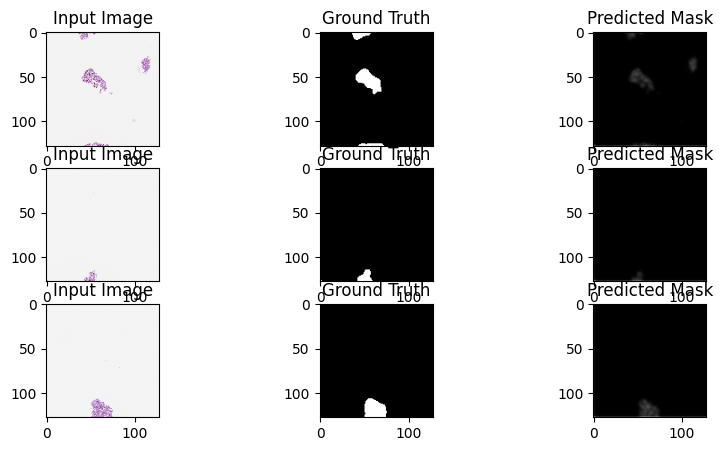

In [7]:
# Get a batch from the validation generator using an index
images, masks = val_generator[0]  # Get the first batch

# Get predictions
predictions = model.predict(images)

# Visualize original image, ground truth mask, and predicted mask
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(3):  # Show 3 examples
    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(images[i])
    plt.title("Input Image")

    plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(masks[i], cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")

plt.show()


In [19]:
model.save("transunet_010__87percent_model.h5")


### Change Loss Function to Dice Loss

In [8]:
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Compile the model with Dice Loss
model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])


In [21]:
# Adjusting the steps_per_epoch
steps_per_epoch = len(train_generator) # 50 # len(train_generator) // batch_size

# Train the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1)

Epoch 1/10
7/7 [==============================] - 425s 4s/step - loss: 0.7984 - accuracy: 0.8439
Epoch 2/10
7/7 [==============================] - 33s 5s/step - loss: 0.8013 - accuracy: 0.4568
Epoch 3/10
7/7 [==============================] - 26s 4s/step - loss: 0.7185 - accuracy: 0.7505
Epoch 4/10
7/7 [==============================] - 53s 8s/step - loss: 0.7141 - accuracy: 0.7865
Epoch 5/10
7/7 [==============================] - 35s 4s/step - loss: 0.6987 - accuracy: 0.7639
Epoch 6/10
7/7 [==============================] - 155s 3s/step - loss: 0.7090 - accuracy: 0.7708
Epoch 7/10
7/7 [==============================] - 26s 4s/step - loss: 0.6974 - accuracy: 0.7723
Epoch 8/10
7/7 [==============================] - 26s 4s/step - loss: 0.6986 - accuracy: 0.7920
Epoch 9/10
7/7 [==============================] - 26s 4s/step - loss: 0.6877 - accuracy: 0.7900
Epoch 10/10
7/7 [==============================] - 27s 4s/step - loss: 0.6832 - accuracy: 0.7819


In [4]:
### try out  with more epochs

# Adjusting the steps_per_epoch
steps_per_epoch = len(train_generator) # 50 # len(train_generator) // batch_size

# Train the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, validation_data=val_generator, 
                    validation_steps=len(val_generator), epochs=50, verbose=1)

Epoch 1/50


UnimplementedError: Graph execution error:

Detected at node 'model/conv2d/Conv2D' defined at (most recent call last):
    File "C:\Users\Muhammadiy\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Muhammadiy\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "D:\virtualenv\DP\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\virtualenv\DP\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "D:\virtualenv\DP\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "D:\virtualenv\DP\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Muhammadiy\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\Muhammadiy\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\Muhammadiy\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\virtualenv\DP\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "D:\virtualenv\DP\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "D:\virtualenv\DP\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "D:\virtualenv\DP\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "D:\virtualenv\DP\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "D:\virtualenv\DP\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\virtualenv\DP\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "D:\virtualenv\DP\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "D:\virtualenv\DP\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\virtualenv\DP\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\virtualenv\DP\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\virtualenv\DP\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Muhammadiy\AppData\Local\Temp\ipykernel_16620\4245222411.py", line 7, in <module>
      history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, validation_data=val_generator,
    File "D:\virtualenv\DP\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\virtualenv\DP\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\virtualenv\DP\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "D:\virtualenv\DP\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\virtualenv\DP\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "D:\virtualenv\DP\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "D:\virtualenv\DP\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\virtualenv\DP\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\virtualenv\DP\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\virtualenv\DP\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\virtualenv\DP\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "D:\virtualenv\DP\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "D:\virtualenv\DP\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\virtualenv\DP\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\virtualenv\DP\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\virtualenv\DP\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "D:\virtualenv\DP\lib\site-packages\keras\layers\convolutional\base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "D:\virtualenv\DP\lib\site-packages\keras\layers\convolutional\base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'model/conv2d/Conv2D'
DNN library is not found.
	 [[{{node model/conv2d/Conv2D}}]] [Op:__inference_train_function_2565]

In [9]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.8851 - loss: 0.9525
Validation Loss: 0.9516602158546448
Validation Accuracy: 0.8803091049194336


1/1 [==============================] - 0s 354ms/step


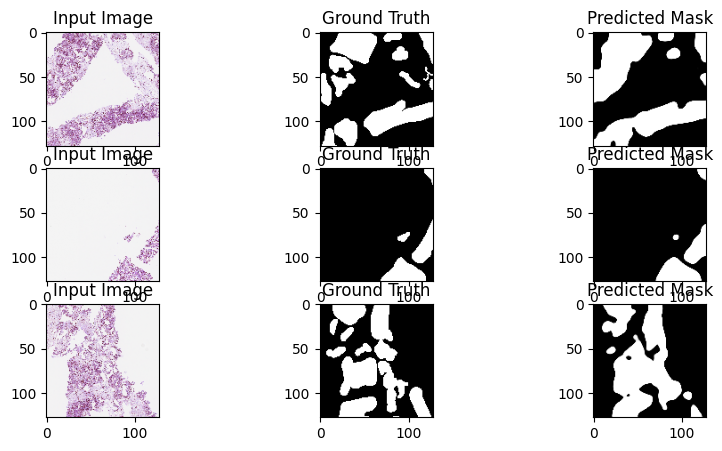

In [23]:
# Get a batch from the validation generator using an index
images, masks = val_generator[0]  # Get the first batch

# Get predictions
predictions = model.predict(images)

# Visualize original image, ground truth mask, and predicted mask
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(3):  # Show 3 examples
    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(images[i])
    plt.title("Input Image")

    plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(masks[i], cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")

plt.show()

In [24]:
model.save("transunet_068__82_percent_with_DICE_loss_model.h5")

In [12]:
# Save the model in SavedModel format
model.save('transunet111.keras', save_format='tf')


### Use Augmentation

In [36]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)


total_samples = 116
total_val_samples = 72

# Define augmentation parameters
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

# Image and mask generators with augmentation
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Training set (with augmentation)
train_image_generator = image_datagen.flow_from_directory(
    image_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode=None,
    shuffle=True,
    seed=42)

train_mask_generator = mask_datagen.flow_from_directory(
    mask_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode=None,
    color_mode='grayscale',
    shuffle=True,
    seed=42)

# Combine the two generators
train_generator = zip(train_image_generator, train_mask_generator)

# Recompile the model with IoU metric
model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])

steps_per_epoch = total_samples // batch_size
val_steps_per_epoch = total_val_samples // batch_size

# Train the model with augmented data
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch
)


Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Epoch 1/20


D:\virtualenv\DP\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7/7 [==============================] - 21s 3s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.6986 - val_accuracy: 0.8272
Epoch 2/20
7/7 [==============================] - 16s 3s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.6831 - val_accuracy: 0.8199
Epoch 3/20
7/7 [==============================] - 15s 2s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.6871 - val_accuracy: 0.8175
Epoch 4/20
7/7 [==============================] - 14s 2s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.6760 - val_accuracy: 0.8290
Epoch 5/20
7/7 [==============================] - 15s 2s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.6762 - val_accuracy: 0.8167
Epoch 6/20
7/7 [==============================] - 14s 2s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.6806 - val_accuracy: 0.8168
Epoch 7/20
7/7 [==============================] - 15s 2s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.6882 - val_accura

In [37]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

4/4 [==============================] - 19s 5s/step - loss: 0.6889 - accuracy: 0.8166
Validation Loss: 0.688949465751648
Validation Accuracy: 0.8166427612304688


1/1 [==============================] - 0s 32ms/step


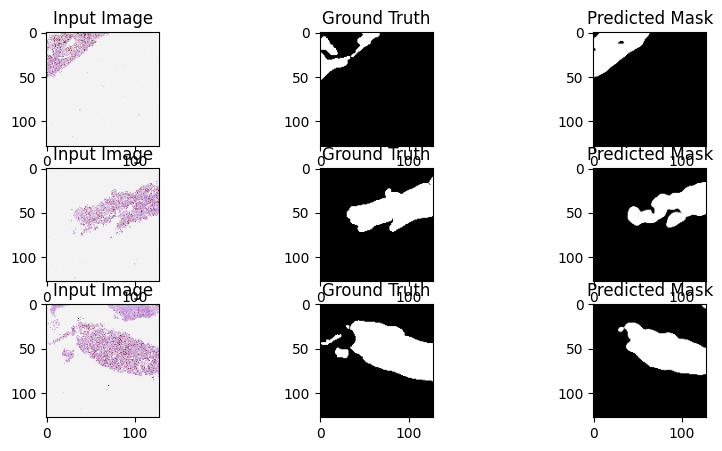

In [38]:
# Get a batch from the validation generator using an index
images, masks = val_generator[0]  # Get the first batch

# Get predictions
predictions = model.predict(images)

# Visualize original image, ground truth mask, and predicted mask
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(3):  # Show 3 examples
    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(images[i])
    plt.title("Input Image")

    plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(masks[i], cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")

plt.show()